# Penguins Classifier


In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn graphviz

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn.tree import export_graphviz
from IPython.display import display

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pandas as pd
sns.set(style="whitegrid")
label_encoder = LabelEncoder()

In [3]:
def prepare_splits(feature, target, splits=[(0.4, 0.6), (0.6, 0.4), (0.8, 0.2), (0.9, 0.1)]):
    """
    Prepares the data by encoding categorical features and splitting into train/test sets.
    
    Arguments:
    - feature: Feature set (DataFrame)
    - target: Target labels (Series or array)
    - splits: Proportions for train/test split (default: 40/60, 60/40, 80/20, 90/10)
    
    Returns:
    - datasets: List of tuples containing the training and testing data (features and labels)
    """
    
    # Encode categorical features
    for column in feature.select_dtypes(include=['object']).columns:  # Identify categorical columns
        feature[column] = label_encoder.fit_transform(feature[column])  # Apply LabelEncoder to each column

    # Initialize list to hold datasets for each split
    datasets = []

    # Split the data based on the proportions defined in 'splits'
    for train_size, test_size in splits:
        feature_train, feature_test, label_train, label_test = train_test_split(
            feature, 
            target,
            train_size=train_size, 
            test_size=test_size,
            stratify=target, 
            shuffle=True, 
            random_state=42
        )
        datasets.append((feature_train, feature_test, label_train, label_test))

    return datasets

In [4]:
def train_model(feature_train, label_train):
    # Arguments:
        # + feature_train: columns those are not target used to train
        # + label_train: column that is target used to train
    
    # Create model of Decision Tree
            # + criterion = 'entropy': Determine the function to evaluate the quality of splitting
            # + random_state=42: Ensures the same training results every time we run it again 
    clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
    # Method training
    # -> It will be trained based on those informations
    
    clf.fit(feature_train, label_train)
    return clf

In [5]:
def train_all_models(datasets):
    # Argument:
        # + datasets: Data after splitting
    # Save trained model of decision trees
    clfs = []
    
    for (feature_train, _, label_train, _) in datasets:
        # call to train_model function to get decision tree
        clf = train_model(feature_train, label_train)
        # add it to a list
        clfs.append(clf)
    return clfs

In [6]:
def evaluate_model(clf, feature_test, label_test, class_names, title=""):
    # Agrument:
        # + clf: trained model of decision tree
        # + feature_test: columns that are not target used to test
        # + label_test: column that is target used to test
        
    # Using the model input (clf) to predict label for feature_test
    label_pred = clf.predict(feature_test)
    
    # generate a report using classification_report
    # print classification_report
    print(classification_report(label_test, label_pred, target_names=class_names))

    # generate a report using confusion_matrix
    cm = confusion_matrix(label_test, label_pred)
    
    # display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    # set the blue color for confusion_matrix
    disp.plot(cmap=plt.cm.Blues)
    # set the titlte for the confusion_matrix
    plt.title(f"Confusion Matrix {title}")
    # no set grid
    plt.grid(False)
    # show the chart
    plt.show()

In [7]:
def evaluate_all(clfs, datasets, class_names):
    # 2.3 Evaluating the decision tree classifiers
    
    #Argument:
        # + clf: list of models of decision tree
        # feature_names: list of feature names
        # class_names: Disease or No disease
    for i, (clf, (feature_train, feature_test, label_train, label_test)) in enumerate(zip(clfs, datasets)):
        # recalculate % train
        percent_train = round(len(feature_train) * 100 / (len(feature_train) + len(feature_test)))
        depth = clf.get_depth()
        percent_test = 100 - percent_train
        # print the title
        print(f"Evaluation Tree {i+1}: ({percent_train:.1f}% train)")
        # call the evaluate_model to draw confusion_matrix
        evaluate_model(clf, feature_test, label_test, class_names, title=f"(Depth = {depth}, {percent_train}/{percent_test} Split)")


In [8]:
def visualize_tree(clf, feature_names, class_names):
    #Argument:
        # + clf: model decision tree
        # feature_names: list of feature names
        # class_names: Disease or No disease
        
    # Convert the decision tree after training to .dot (graph description text format). For drawing decision trees.
            # + clf: Decision tree model
            # + out_file = None: Instead of writting to file, it returns the description string
            # + filled=True: fill color
            # + rounded=True: rounded shapes
            # + special_characters: allow using the special_characters in labels or features
    dot_data = export_graphviz(
        clf, out_file=None,
        feature_names=feature_names,
        class_names=class_names,
        filled=True, rounded=True, special_characters=True
    )
    # Initialize the graph by the above description string
    graph = graphviz.Source(dot_data)
    display(graph)

In [9]:
def visualize_all(clfs, feature_names, class_names, splits):
    # 2.2 Building the decision tree classifiers

    #Argument:
        # + clf: list of models of decision tree
        # feature_names: list of feature names
        # class_names: Disease or No disease
    for i, clf in enumerate(clfs):
        print(f"Dataset {(splits[i][0] * 100):.0f}/{(splits[i][1] * 100):.0f} Split")
        visualize_tree(clf, feature_names, class_names)

In [10]:
def plot_class_distributions(datasets, splits, title):
    #Argument:
        # + datasets: For data after we split
        # + slipts: the proportions
        # + title: Name of the this data 
    
    # Draw the chart for test and train
    
    # For each pair of datasets: 
    for i, (__, __, label_train, label_test) in enumerate(datasets):
        
        # Create the figure with 2 charts in 1 line (1, 2), each chart has width: 10 inch, height 4 inch
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))
        
        # axs[0] mean the first chart (train)
        # x for the x axis. It takes lables from label_train (like 0,1)
        sns.countplot(x=label_train, ax=axs[0])
        
        # Set the name for the first chart
        axs[0].set_title(f"Train {int(splits[i][0]*100)}%")  
        
        # axs[1] mean the second chart (test)
        # It takes lables from y_tes
        sns.countplot(x=label_test, ax=axs[1]) 
        
        # Set the name for the second chart
        axs[1].set_title(f"Test {int(splits[i][1]*100)}%")
        
        for ax in axs:
            
            ax.set_xlabel("Target") # x axis presents Tagert (0,1)
            ax.set_ylabel("Count") # y axis presents Quantity 
            
            # True: show the grid to read easily
            # line: grid draw by "--"
            # alpha: opacity of the grid 
            ax.grid(True, linestyle="--", alpha=0.5)

            for p in ax.patches:
                height = p.get_height()
                ax.annotate(f'{int(height)}', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 9), textcoords='offset points') 
        
        plt.suptitle(title + f" {int(splits[i][0]*100)}/{int(splits[i][1]*100)}") 
        plt.tight_layout() # For the aesthetic
        plt.show()

In [11]:
def plot_original_distribution(target, title="Original Dataset"):
    # Draw the chart of the original data 
    ax = sns.countplot(x=target)
    for p in ax.patches:
        height = p.get_height() 
        ax.annotate(f'{int(height)}', 
        (p.get_x() + p.get_width() / 2., height),  
        ha='center', va='center',  
        fontsize=12, color='black', 
        xytext=(0, 9), textcoords='offset points')
    plt.title(title) # set title
    plt.xlabel("Label") # set x axis title
    plt.ylabel("Count") # set y axis title
    plt.grid(True, linestyle="--", alpha=0.5) # Same
    plt.show()

In [12]:
def analyze_accuracy_vs_depth(dataset, feature_names, class_names, max_depth_values=[None, 2, 3, 4, 5, 6, 7]):
    
    
    
    #2.4 The depth and accuracy of a decision tree

    
    import pandas as pd
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.metrics import accuracy_score
    # Take the data 80/20
    X_train, X_test, y_train, y_test = dataset
    # Save the result
    results = []

    # For each depth [None, 2, 3, 4, 5, 6, 7]
    for depth in max_depth_values:
        
        # Set up for the decision tree but we add one more variable max_depth
        # Re-trained with limited depth requirement
        clf = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        # Calculate by take the right predicts divide to total predicts
        acc = accuracy_score(y_test, y_pred)
        
        # Save the current depth
        results.append(("None" if depth is None else depth, acc))
        # Convert to string
        dot_data = export_graphviz(
            clf, out_file=None,
            feature_names=feature_names,
            class_names=class_names,
            filled=True, rounded=True, special_characters=True
        )
        # Create graph based on string
        graph = graphviz.Source(dot_data)
        print(f"Decision Tree with max_depth = {depth}, Accuracy = {acc:.4f}")
        display(graph)

    # For report the accuracy_score (on the test set) of the decision tree classifier for each value of the max_depth parameter.
    return pd.DataFrame(results, columns=["max_depth", "accuracy"]) 

In [13]:
def plot_accuracy_vs_depth(results, title="Accuracy vs. Tree Depth"):
    
    df = results.copy()
  
    mask_none = df["max_depth"] == "None"
    df_numeric = df[~mask_none]
    df_none    = df[ mask_none]
    
    
    df_ordered = pd.concat([df_numeric, df_none], ignore_index=True)
    
    
    df_ordered["x"] = df_ordered.index
    
    
    plt.figure()
    plt.plot(df_ordered["x"], df_ordered["accuracy"], marker='o')
  
    plt.xticks(df_ordered["x"], df_ordered["max_depth"])
    
    plt.xlabel("max_depth")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.grid(True)
    plt.show()

In [14]:
dataset_path = "Data/penguinsData.csv"

In [15]:
# Initialization
penguins_df = pd.read_csv(dataset_path)
feature = penguins_df.drop("Species", axis=1)
label = penguins_df["Species"]

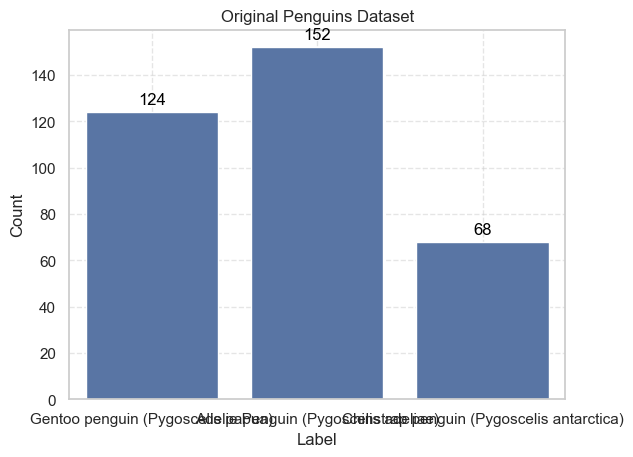

In [16]:
# Show the chart of original data
plot_original_distribution(label, "Original Penguins Dataset")

In [17]:
# set up the proportions
splits = [(0.4, 0.6), (0.6, 0.4), (0.8, 0.2), (0.9, 0.1)]
# Implement preparing data 
datasets = prepare_splits(feature, label, splits)

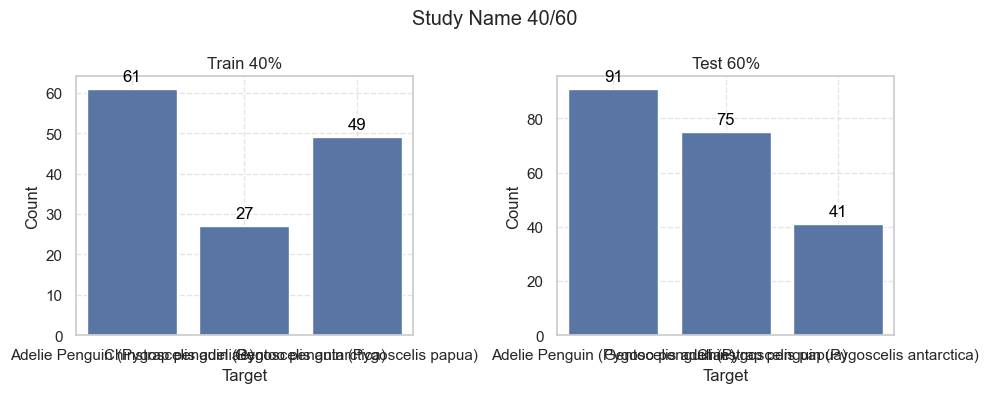

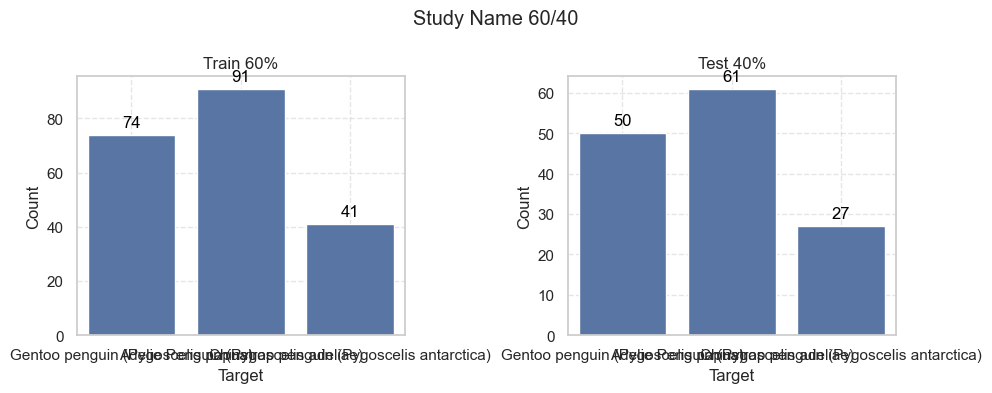

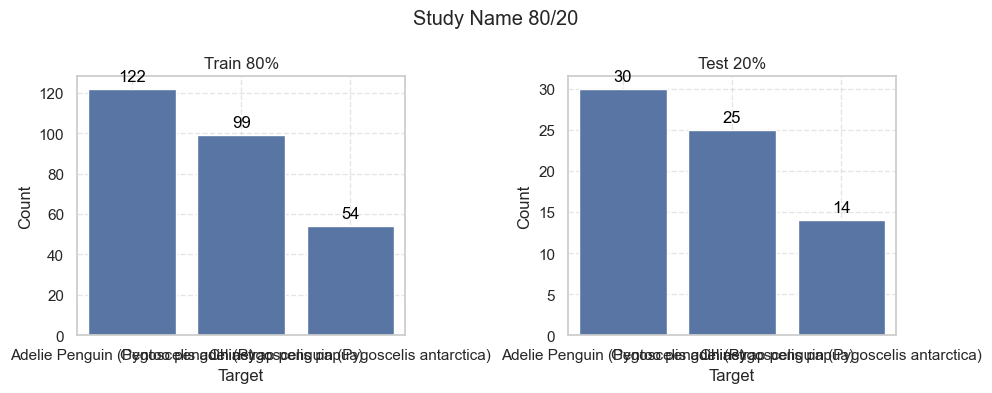

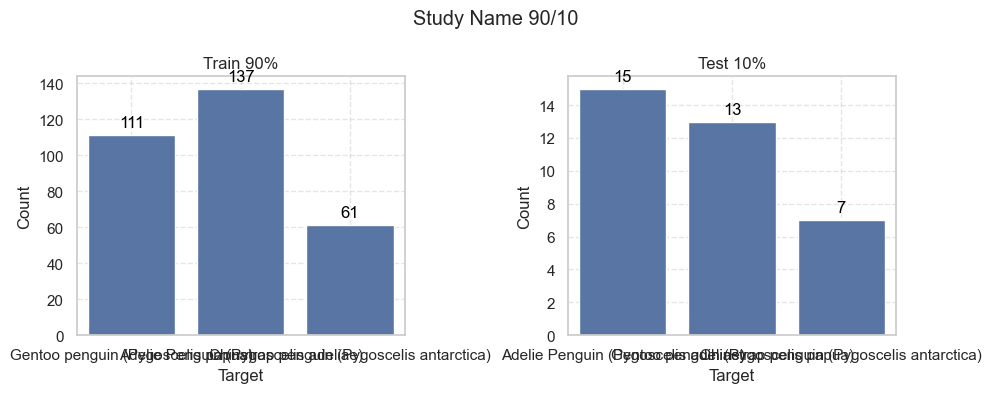

In [18]:
# show charts of datasets after we "preparing" 
plot_class_distributions(datasets, splits, "Study Name")


Dataset 40/60 Split


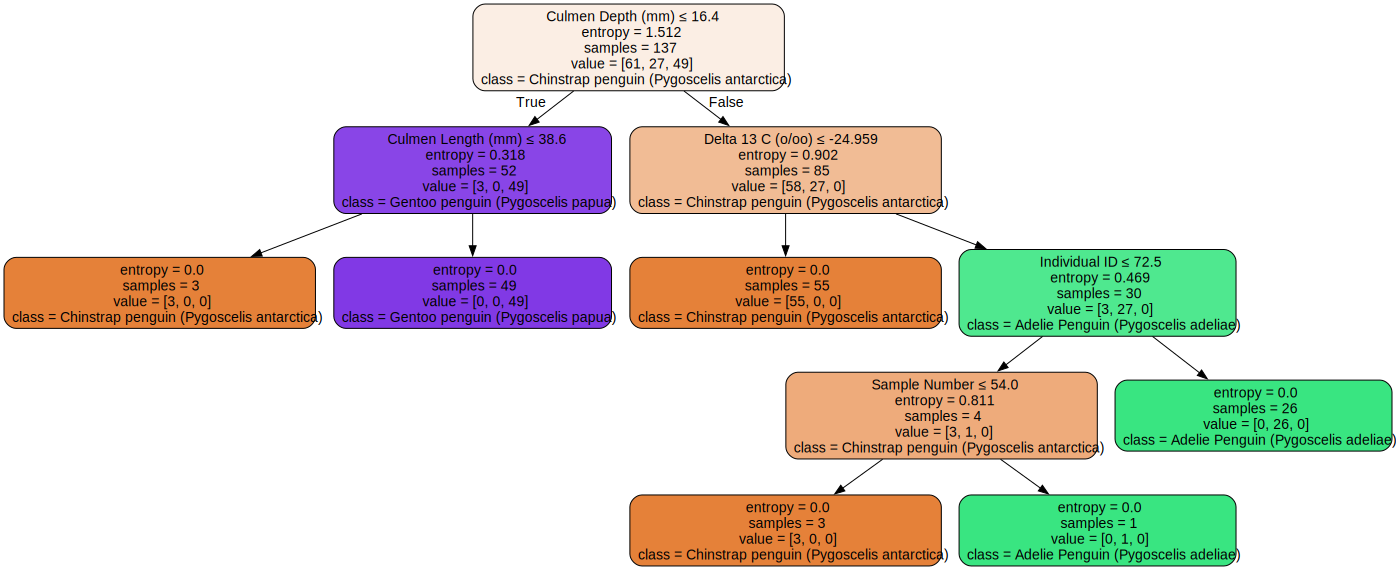

Dataset 60/40 Split


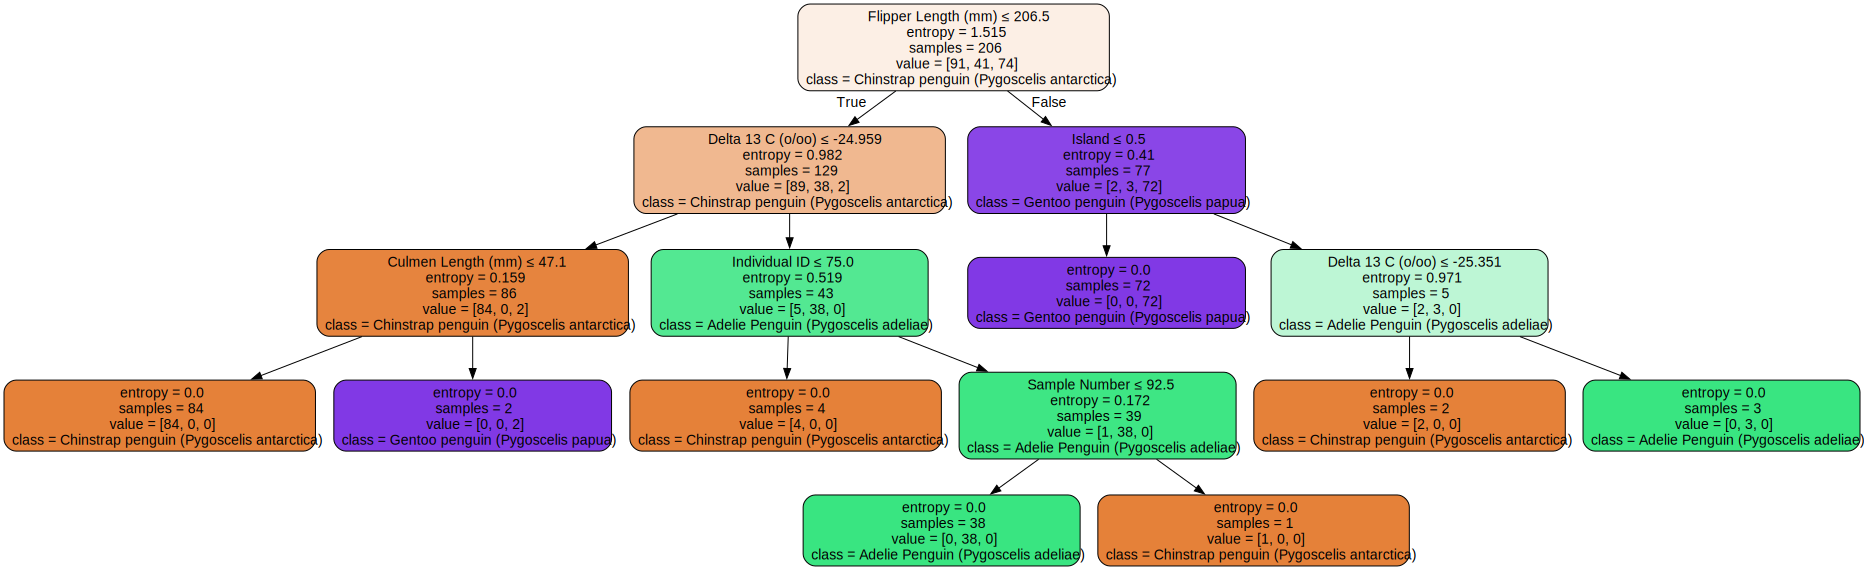

Dataset 80/20 Split


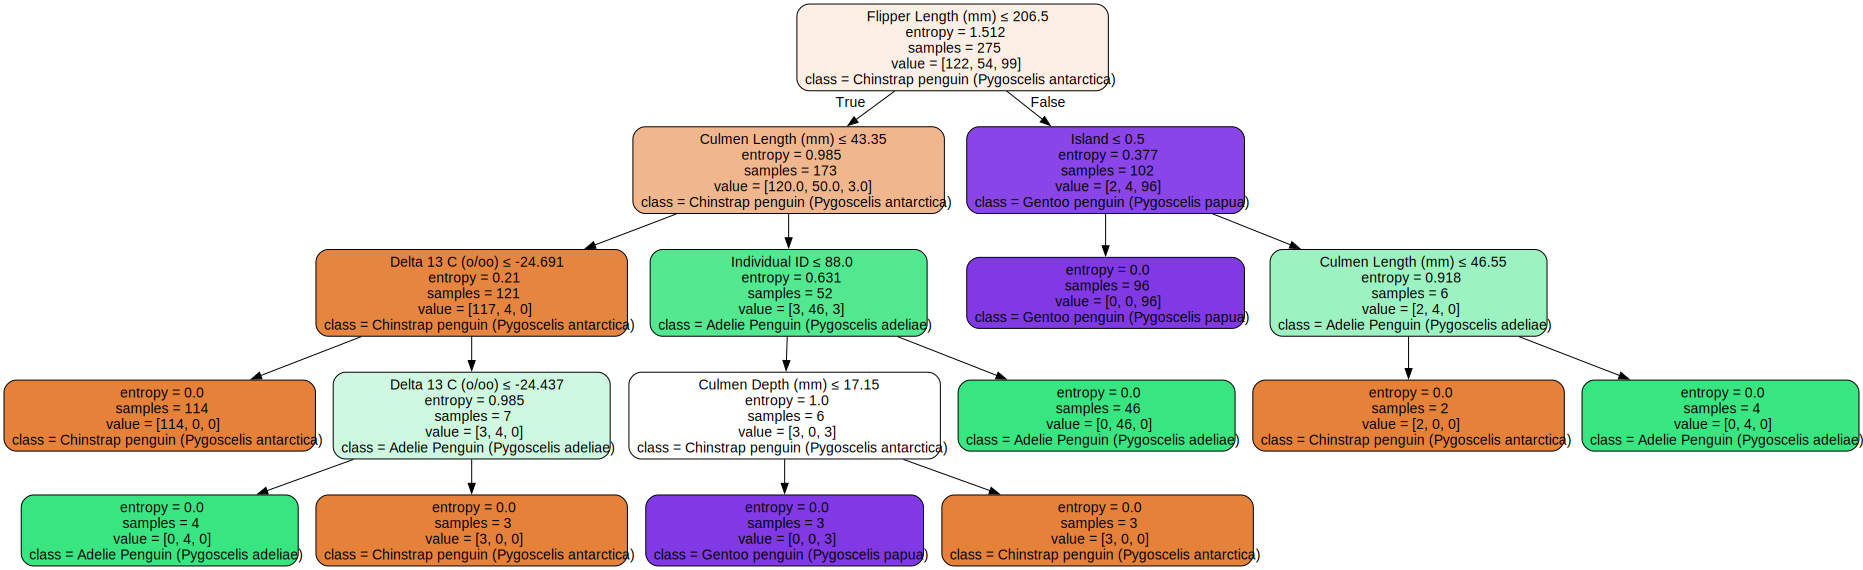

Dataset 90/10 Split


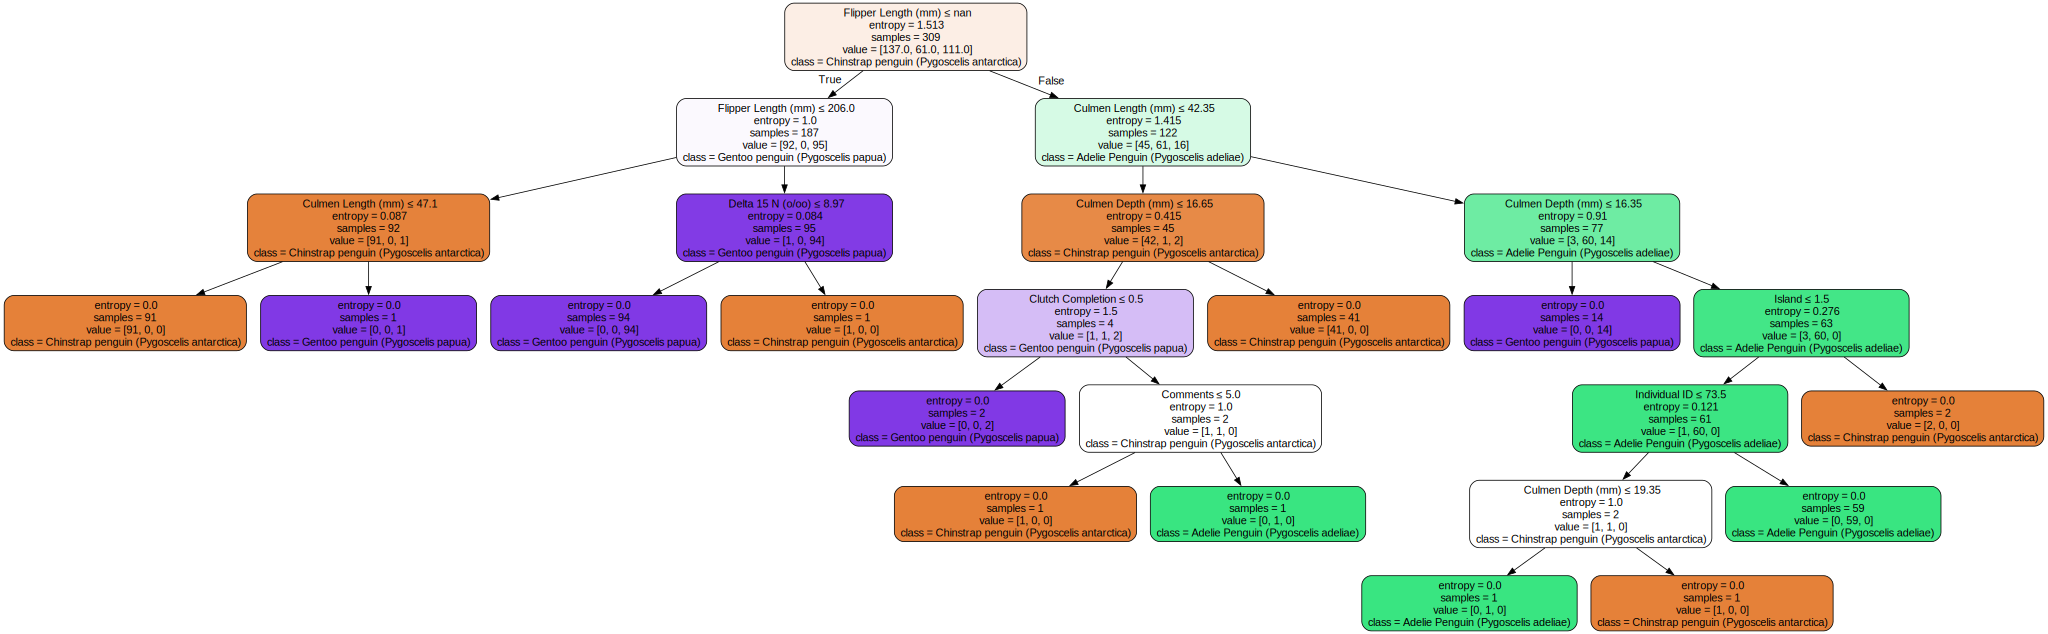

In [19]:
# train data
clfs = train_all_models(datasets)
# visualize the trees based on trained models of datasets (clfs)
visualize_all(
              clfs, 
              feature_names=feature.columns.tolist(), 
              class_names=["Chinstrap penguin (Pygoscelis antarctica)", 
                            "Adelie Penguin (Pygoscelis adeliae)",
                            "Gentoo penguin (Pygoscelis papua)"], splits = splits
            )

Evaluation Tree 1: (40.0% train)
                                           precision    recall  f1-score   support

Chinstrap penguin (Pygoscelis antarctica)       0.88      0.98      0.93        91
      Adelie Penguin (Pygoscelis adeliae)       0.95      0.90      0.93        41
        Gentoo penguin (Pygoscelis papua)       0.99      0.88      0.93        75

                                 accuracy                           0.93       207
                                macro avg       0.94      0.92      0.93       207
                             weighted avg       0.93      0.93      0.93       207



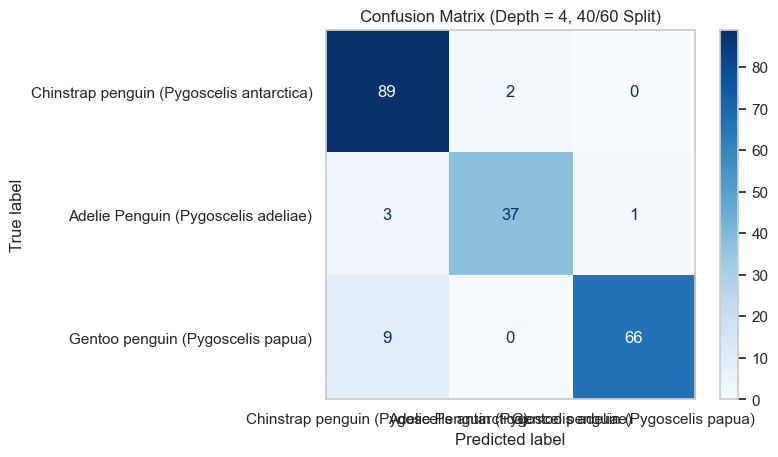

Evaluation Tree 2: (60.0% train)
                                           precision    recall  f1-score   support

Chinstrap penguin (Pygoscelis antarctica)       0.95      0.98      0.97        61
      Adelie Penguin (Pygoscelis adeliae)       0.96      0.85      0.90        27
        Gentoo penguin (Pygoscelis papua)       0.96      0.98      0.97        50

                                 accuracy                           0.96       138
                                macro avg       0.96      0.94      0.95       138
                             weighted avg       0.96      0.96      0.96       138



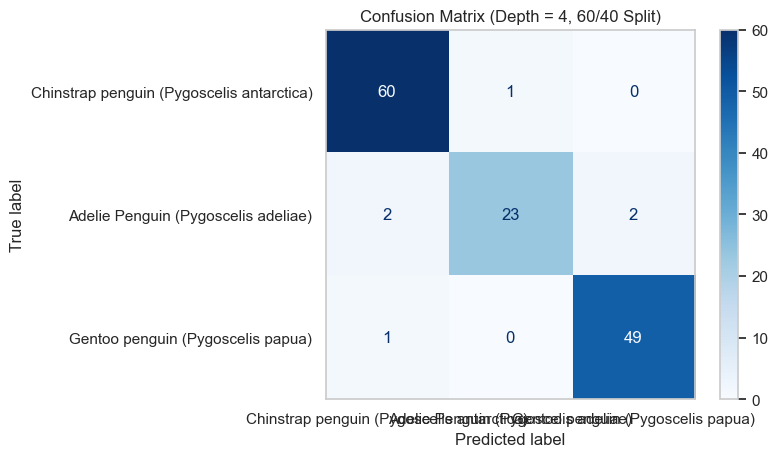

Evaluation Tree 3: (80.0% train)
                                           precision    recall  f1-score   support

Chinstrap penguin (Pygoscelis antarctica)       0.94      0.97      0.95        30
      Adelie Penguin (Pygoscelis adeliae)       0.92      0.86      0.89        14
        Gentoo penguin (Pygoscelis papua)       1.00      1.00      1.00        25

                                 accuracy                           0.96        69
                                macro avg       0.95      0.94      0.95        69
                             weighted avg       0.96      0.96      0.96        69



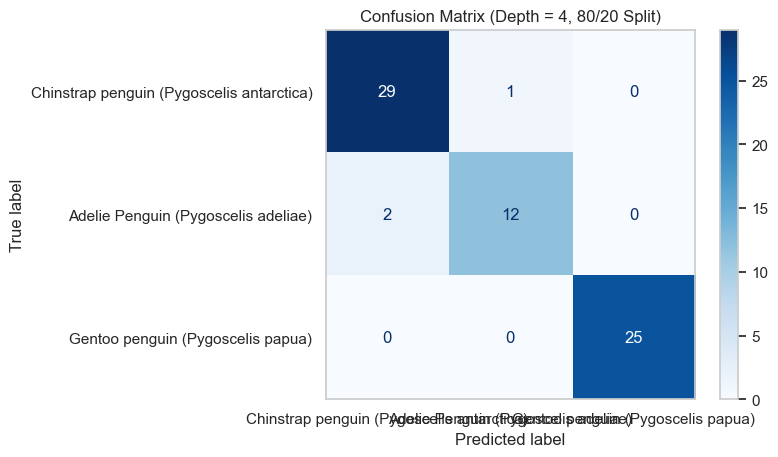

Evaluation Tree 4: (90.0% train)
                                           precision    recall  f1-score   support

Chinstrap penguin (Pygoscelis antarctica)       1.00      0.93      0.97        15
      Adelie Penguin (Pygoscelis adeliae)       0.78      1.00      0.88         7
        Gentoo penguin (Pygoscelis papua)       0.92      0.85      0.88        13

                                 accuracy                           0.91        35
                                macro avg       0.90      0.93      0.91        35
                             weighted avg       0.92      0.91      0.92        35



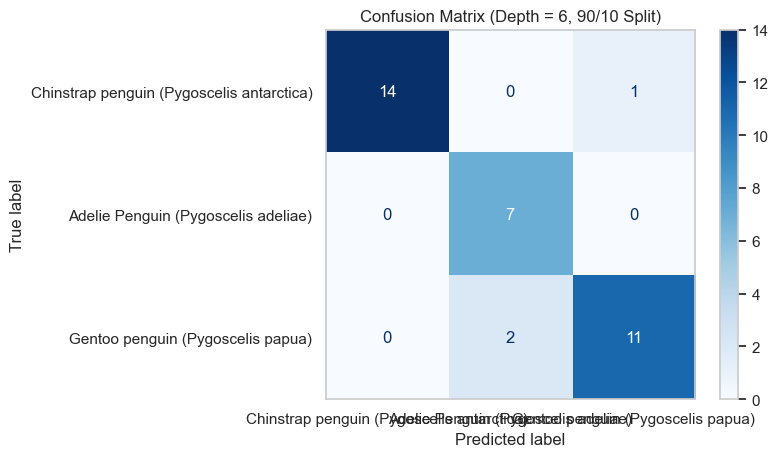

In [20]:
evaluate_all(clfs, 
             datasets, 
             class_names=["Chinstrap penguin (Pygoscelis antarctica)", 
                          "Adelie Penguin (Pygoscelis adeliae)",
                          "Gentoo penguin (Pygoscelis papua)"])


Decision Tree with max_depth = None, Accuracy = 0.9565


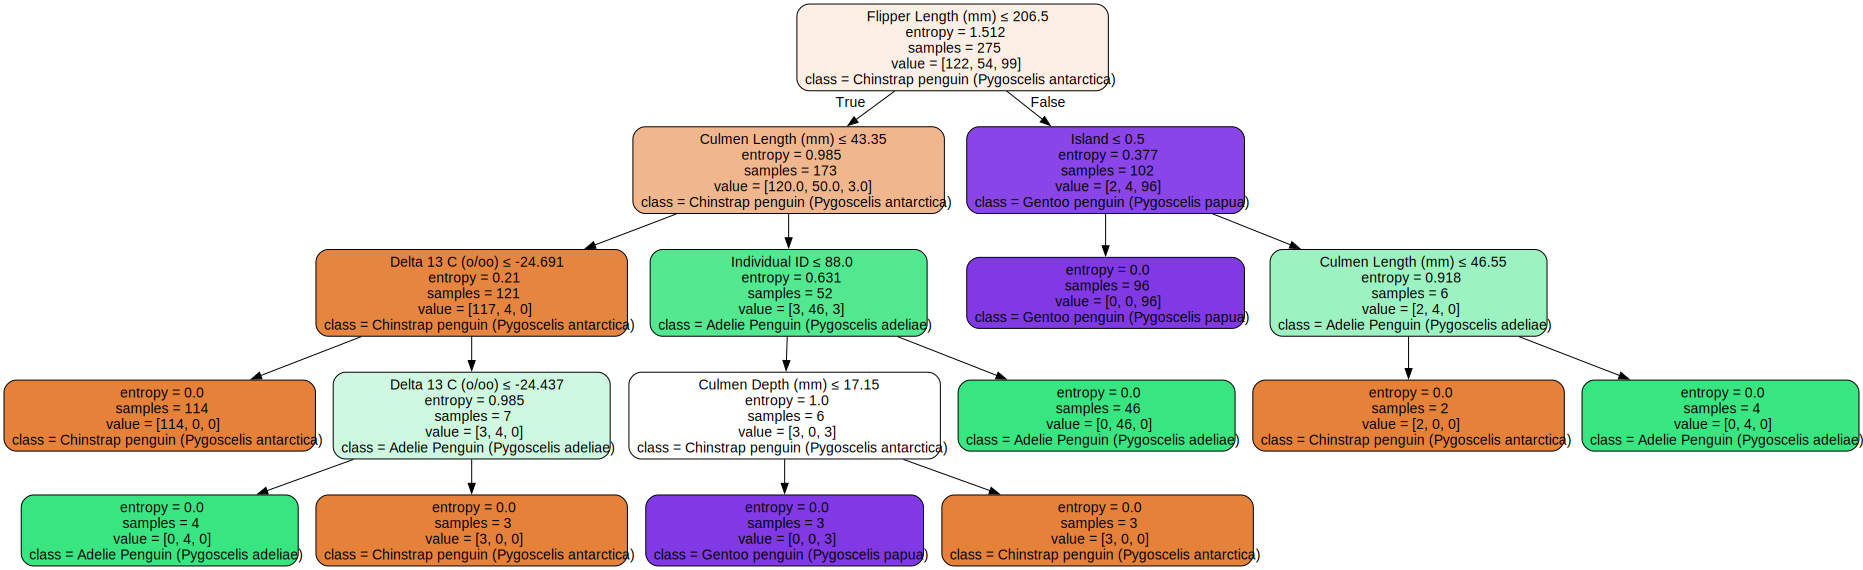

Decision Tree with max_depth = 2, Accuracy = 0.9565


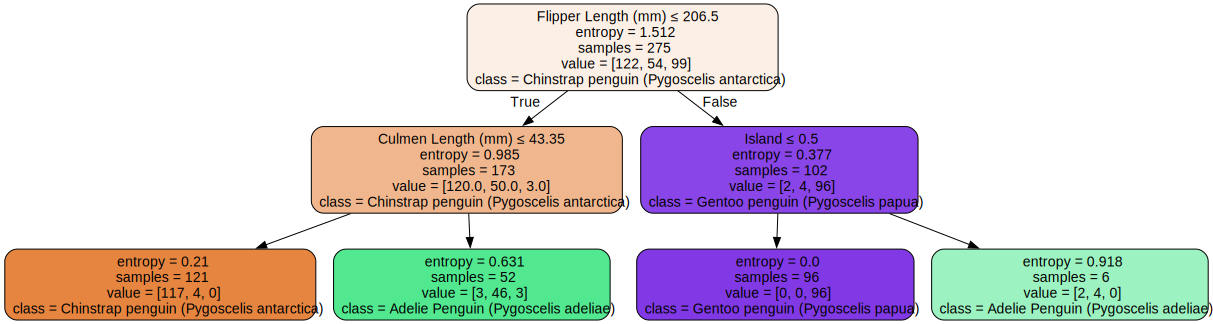

Decision Tree with max_depth = 3, Accuracy = 0.9275


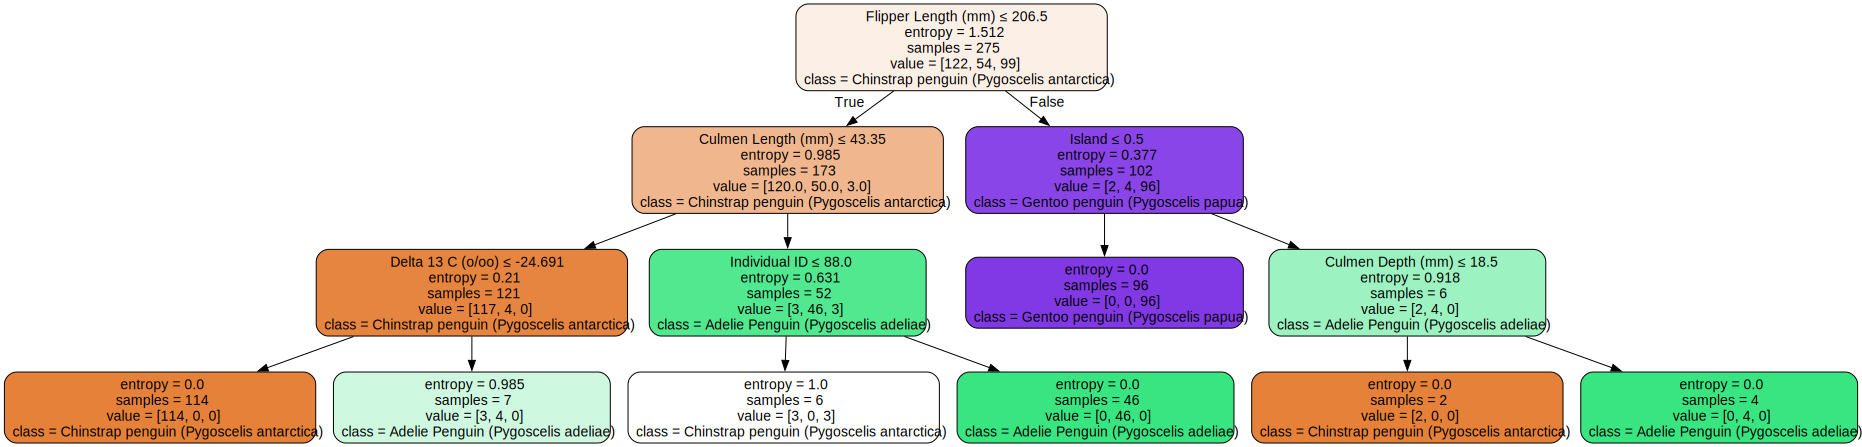

Decision Tree with max_depth = 4, Accuracy = 0.9565


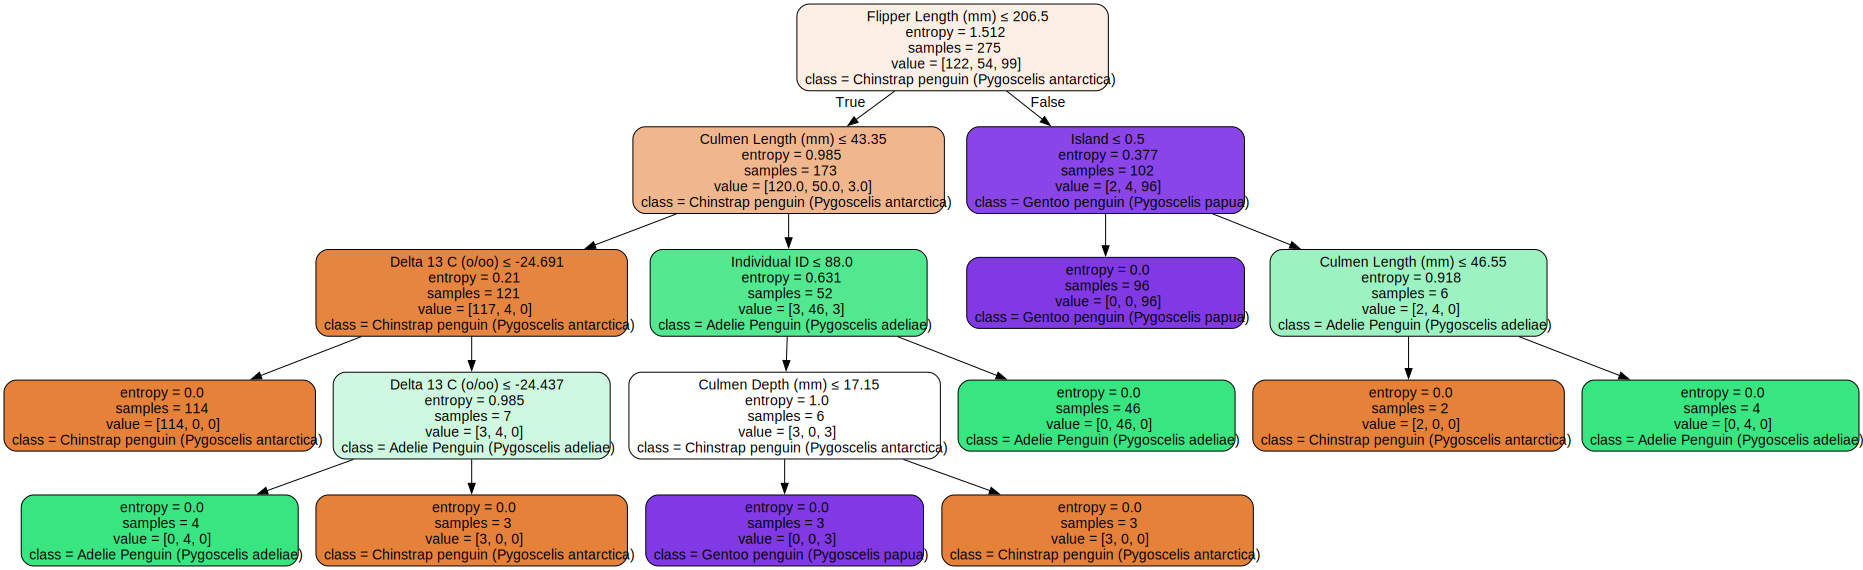

Decision Tree with max_depth = 5, Accuracy = 0.9565


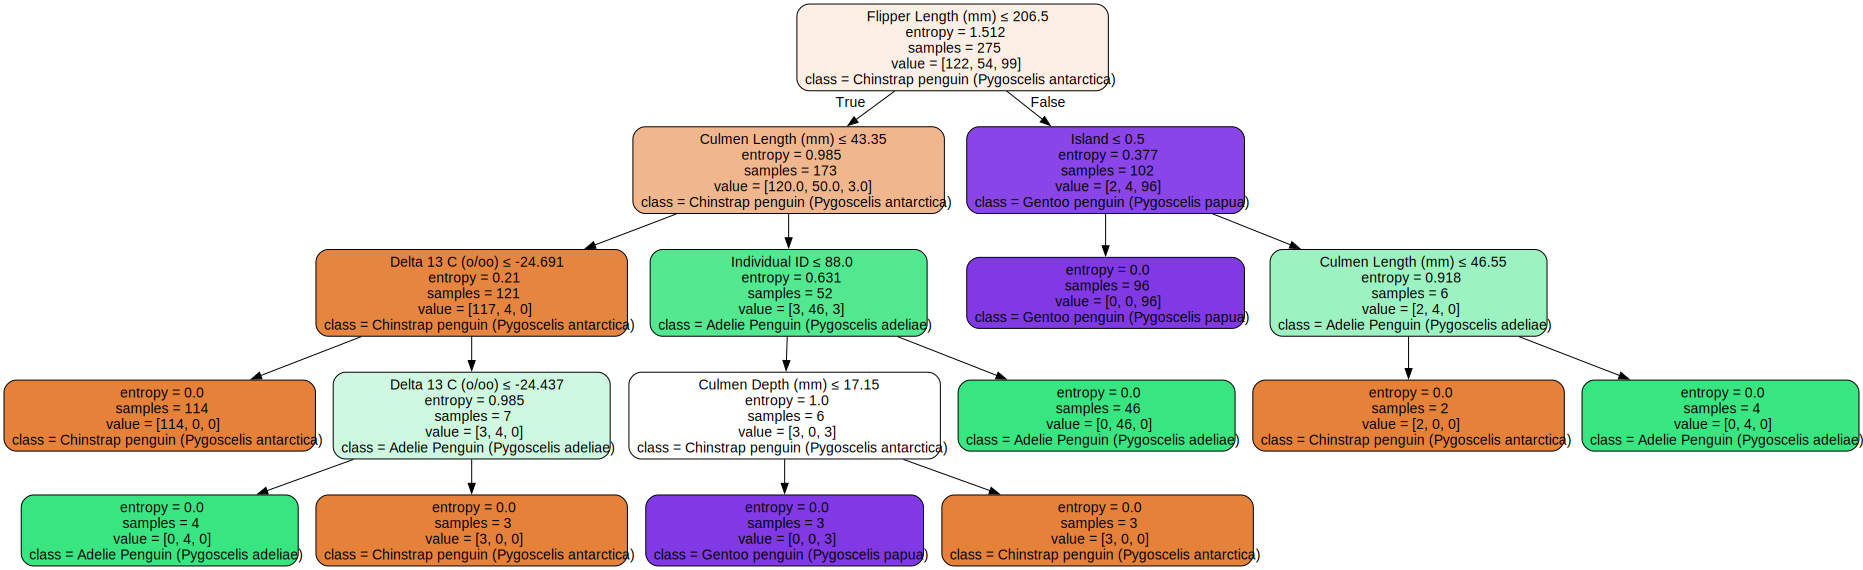

Decision Tree with max_depth = 6, Accuracy = 0.9565


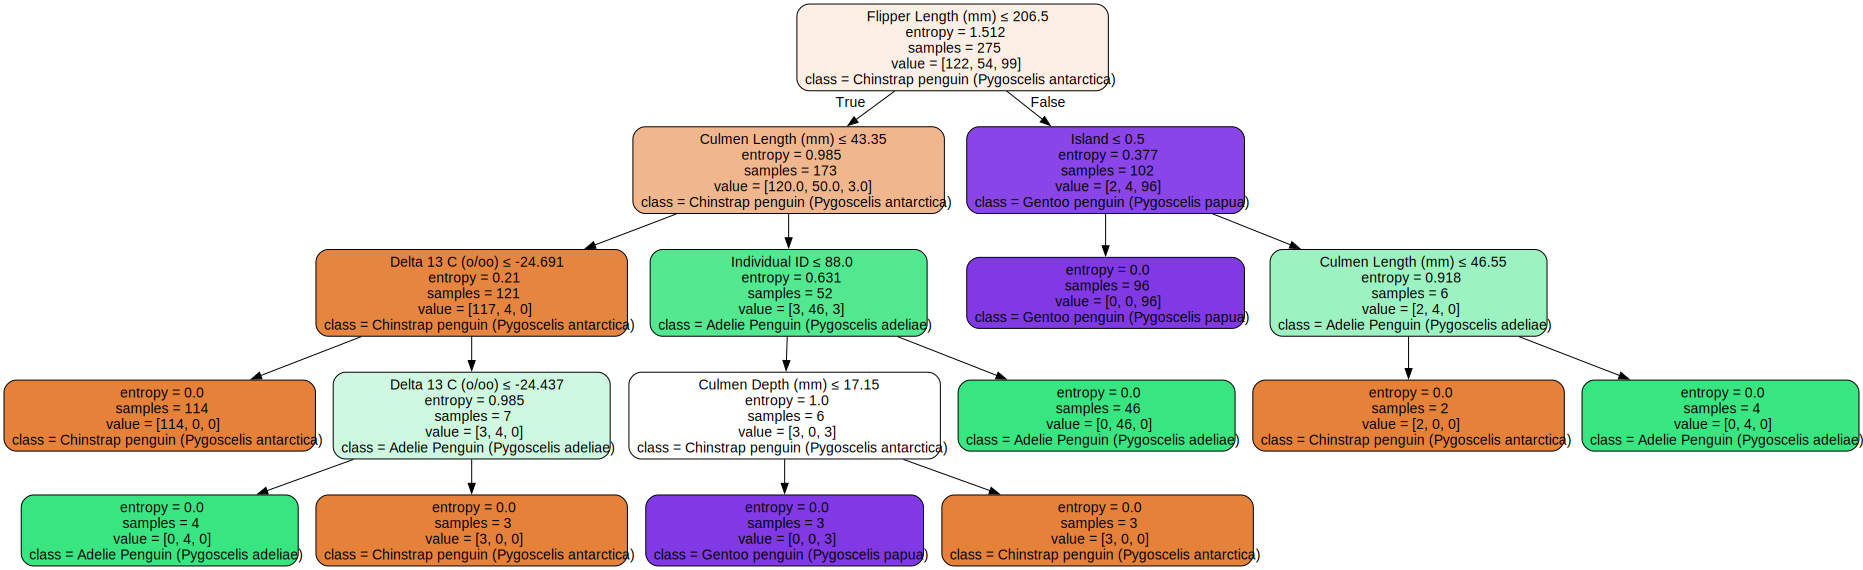

Decision Tree with max_depth = 7, Accuracy = 0.9565


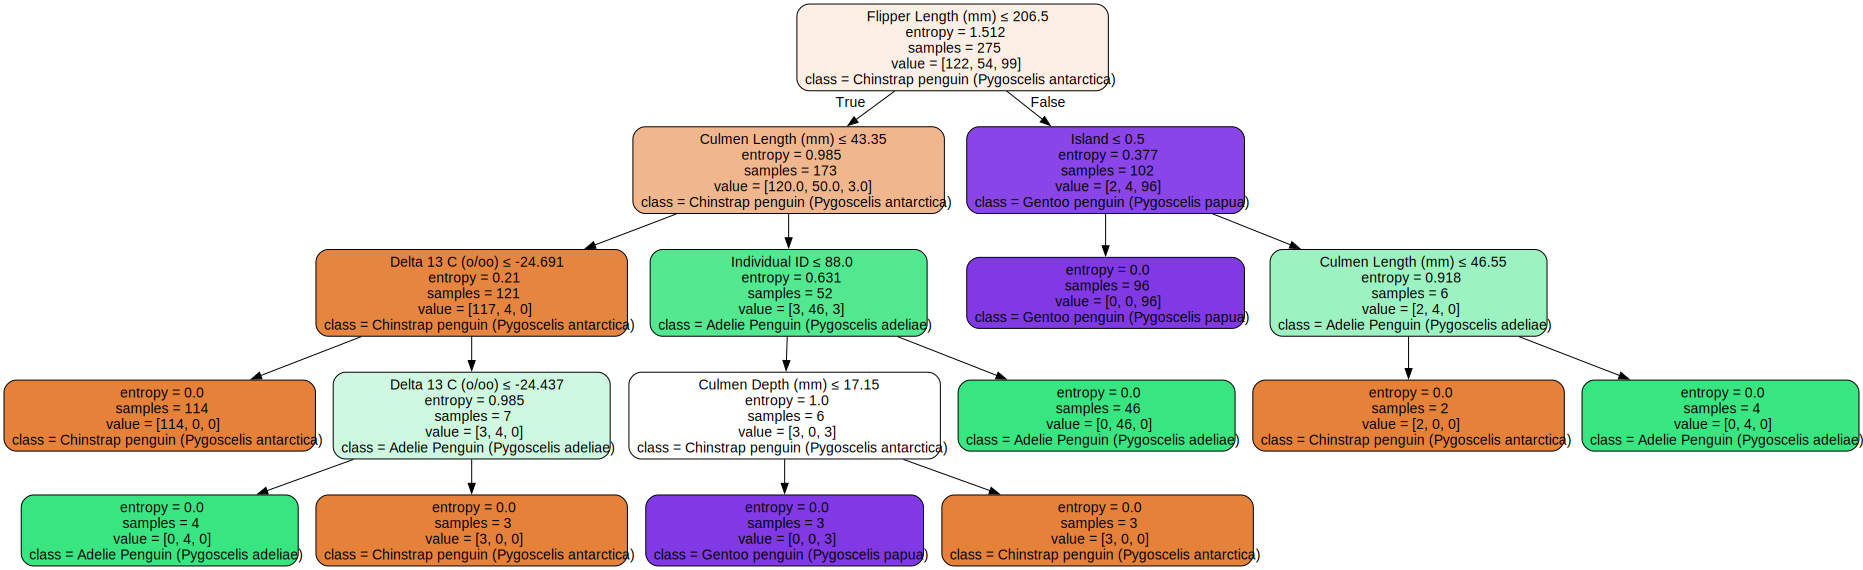

,max_depth,accuracy
0,None,0.956522
1,2,0.956522
2,3,0.927536
3,4,0.956522
4,5,0.956522
5,6,0.956522
6,7,0.956522


In [21]:
results_df = analyze_accuracy_vs_depth(dataset=datasets[2],
                                       feature_names=feature.columns.tolist(),
                                       class_names=["Chinstrap penguin (Pygoscelis antarctica)", 
                                                    "Adelie Penguin (Pygoscelis adeliae)",
                                                    "Gentoo penguin (Pygoscelis papua)"])

results_df

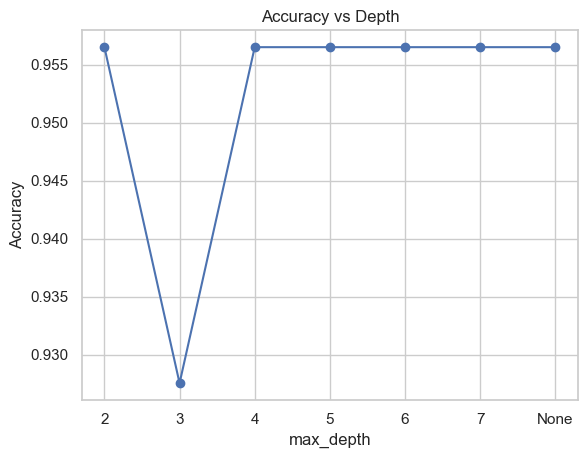

In [22]:
# line chart between Accuracy and Depth
plot_accuracy_vs_depth(results_df, title="Accuracy vs Depth")